# Analyzing SASUMO outputs


### Import the Required Libraries


In [1]:
import os
import sys
import pathlib
from copy import deepcopy


In [2]:
def find_root(path):
    if os.path.split(path)[-1] != "airport-harper-sumo":
        return find_root(os.path.split(path)[0])
    return path


In [3]:
# !pip install -e "/Users/max/Development/airport-harper-sumo/SASUMO"

In [4]:
import pathlib

PATH = find_root(pathlib.Path().absolute())
if PATH not in sys.path:
    print(f"adding {PATH} to path")
    sys.path.append(PATH)


adding /Users/max/Development/airport-harper-sumo to path


In [5]:
import json5 as json
import sys

import numpy as np
import pandas as pd
import plotly.graph_objects as go
import plotly.express as px
from plotly.subplots import make_subplots

from SALib.analyze import sobol
from SALib.analyze import pawn, delta

from SASUMO.params import SASUMOConf

# from SASUMO.params import SASUMOConf, ReplayProcessConf


In [6]:
NAME_2_LATEX = {
    "RandomSeed": r"$\large{\text{seed}}$",
    "Tau": r"$\large{\tau}$",
    "TauDev": r"$\large{\tau^{\sigma}}$",
    "TauDist": r"$\large{\tau^{\text{dist}}}$",
    "Accel": r"$\large{a}$",
    "AccelDev": r"$\large{a^{\sigma}}$",
    "AccelDist": r"$\large{a^{\text{dist}}}$",
    "Decel": r"$\large{b}$",
    "DecelDev": r"$\large{b^{\sigma}}$",
    "DecelDist": r"$\large{b^{\text{dist}}}$",
    "minGap": r"$\large{s_0}$",
    "minGapDev": r"$\large{s_0^{\sigma}}$",
    "minGapDist": r"$\large{s_0^{\text{dist}}}$",
    "speedFactor": r"$\large{\text{SF}_v}$",
    "speedDeviation": r"$\large{\text{SF}_{v}^{\sigma}}$",
    "speedFactorDist": r"$\large{\text{SF}_{v}^{\text{dist}}}$",
    "impatience": r"$\large{\text{impatience}}$",
    "impatienceDev": r"$\large{\text{impatience}^{\sigma}}$",
    "lcStrategic": r"$\large{\text{lcStrategic}}$",
    "lcStrategicDev": r"$\large{\text{lcStrategic}^{\sigma}}$",
    "lcAssertive": r"$\large{\text{lcAssertive}}$",
    "lcAssertiveDev": r"$\large{\text{lcAssertive}^{\sigma}}$",
    "fleetComposition": r"$\large{p_{\text{truck}}}$",
    'truckSpeedFactor': r'$\large{\text{SF}_{\text{truck}}}$',
    'truckAccel': r"$\large{a_{\text{truck}}}$",
    'truckTau': r'$\large{\tau_{\text{truck}}}$',
    'truckDecel': r"$\large{b_{\text{truck}}}$"
}


## Open up the Simulations


In [7]:
from dataclasses import dataclass


@dataclass
class FileHandler:

    root: str
    results: pd.DataFrame = None
    si_df: pd.DataFrame = None
    _p: dict = None

    @property
    def problem(
        self,
    ):
        if not self._p:
            p = os.path.join(self.root, "SALib_Problem.json")
            self._p = json.load(open(p))
        return self._p

    @property
    def results_csv(
        self,
    ):
        return os.path.join(self.root, "processed_results.csv")

    @property
    def sample_file(
        self,
    ):
        return os.path.join(self.root, "SALib_Samples.txt")

    @property
    def sasumo_conf(
        self,
    ):
        return os.path.join(self.root, "sasumo_params.yaml")

    @property
    def results_csv(
        self,
    ):
        return os.path.join(self.root, "processed_results.csv")

    def load_results(
        self,
    ):
        self.results = pd.read_csv(self.results_csv)


In [8]:
PATH = "/Users/max/tmp/PaperFinalFleetCompositionFinalV0"


In [9]:
SAs = {}
for _dir in os.scandir(PATH):
    if _dir.is_dir():
        file_handler = FileHandler(_dir.path)
        try:
            n = SASUMOConf.static_reload(file_handler.sasumo_conf).SensitivityAnalysis.N
            SAs[n] = file_handler
            SAs[n].load_results()
        except FileNotFoundError:
            print(
                _dir,
            )


## Creating a table of the Results and Parameters


### Calculating Watiting Time Ratio


In [10]:
import itertools

MAINLINE_PHASES = ["1", "2", "5", "6"]
SIDE_PHASES = ["3", "4", "7", "8"]

TL = ["63082002", "63082003", "63082004"]

MAINLINE_SUMBOIS = [
    f"{tl}_{p}_meanTimeLoss"
    for tl, p in itertools.product(TL, MAINLINE_PHASES)
    if tl != "63082002" and p not in ["1", "3", "7", "8"]
]
SIDESTREET_SUMBOIS = [
    f"{tl}_{p}_meanTimeLoss"
    for tl, p in itertools.product(TL, SIDE_PHASES)
    if tl != "63082002" and p not in ["1", "3", "7", "8"]
]


In [11]:
for n, fh in SAs.items():
    fh.results["mainline_timeloss"] = fh.results[MAINLINE_SUMBOIS].sum(axis=1)
    fh.results["sidestreet_timeloss"] = fh.results[SIDESTREET_SUMBOIS].sum(axis=1)
    fh.results["timeloss_ratio"] = fh.results["sidestreet_timeloss"] / (
        fh.results["mainline_timeloss"] + fh.results["sidestreet_timeloss"]
    )


### Creating a Side Street FC Ratio


In [12]:
import plotly.figure_factory as ff


fig = ff.create_distplot(
    [
        fh.results.loc[fh.results.cal_score >= 1, "Fuel_L"].values,
        fh.results.loc[fh.results.cal_score < 1, "Fuel_L"].values,
        fh.results["Fuel_L"].values,
        
    ],
    group_labels=['calibrated', 'not calibrated', "all"],
    bin_size=2,
    show_rug=False
)
fig.show()


## Plotting Calibration


In [13]:
for n, fh in SAs.items():
    print(
        f"{n}: Percentage that fail calibration: {(sum(fh.results.cal_score < 1) / len(fh.results)) * 100}%"
    )


1024: Percentage that fail calibration: 2.6834239130434785%


In [14]:
sum(fh.results.cal_score < 1)

1264

### Average Fleet Composition vs. Average Fleet Composition for Simulations that Fail Calibration

In [45]:
# find correlation between fleet Composition and calibration score
import scipy.stats as stats


fh.results[["cal_score_2", "Accel", "fleetComposition"]].corr()

cal_score_2     Accel  fleetComposition
cal_score_2          1.000000  0.058464         -0.168868
Accel                0.058464  1.000000          0.000218
fleetComposition    -0.168868  0.000218          1.000000

In [43]:
# plot a 2d histogram of the results
import plotly.express as px
import plotly.graph_objects as go

fig = go.Figure()

fig.add_trace(
    go.Histogram2d(
        x=fh.results.loc[fh.results.cal_score < 1, "fleetComposition"],
        y=fh.results.loc[fh.results.cal_score < 1, "Accel"],
        name="calibrated",
        # ncontours=20,
        colorscale="Blues",
        showscale=False,
        reversescale=True,
    )
)



In [24]:
fh.results.loc[fh.results.cal_score < 1, "fleetComposition"].describe()

count    1264.000000
mean        0.177193
std         0.059029
min         0.030322
25%         0.142041
50%         0.189736
75%         0.228838
max         0.249678
Name: fleetComposition, dtype: float64

In [25]:
fh.results["fleetComposition"].describe()

count    47104.000000
mean         0.140000
std          0.063509
min          0.030107
25%          0.085054
50%          0.140000
75%          0.194946
max          0.249893
Name: fleetComposition, dtype: float64

### Average Acceleration vs. Average Acceleration for Simulations that Fail Calibration

<AxesSubplot:>

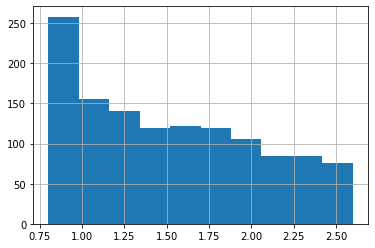

In [33]:
fh.results.loc[fh.results.cal_score < 1, "Accel"].hist()

<AxesSubplot:>

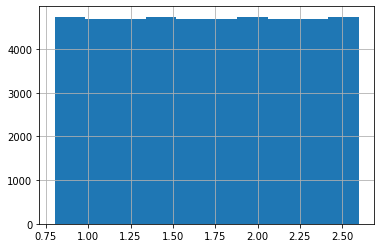

In [34]:
fh.results["Accel"].hist()

In [15]:
fh.results.Fuel_L.quantile(0.95)

795.7570994893381

## Perform the Sobol


In [26]:
SI_COLUMNS = [
    "f_out",
    "all_travel_time_average",
    "all_delay_average",
    "timeloss_ratio",
    "cal_score_2",
    # "fc_ratio"
    # "all_travel_time_quantile_95",
    # "all_fuel_energy_average",
    # "fuel_avg",
    # "mainline_timeloss"
]

PRETTY_COLUMNS = [
    "Fuel Consumption",
    "Average Travel Time",
    "Average Delay",
    "Ratio of Delay",
    "Calibration Score"
    
    # "Average Fuel Energy",
    # "Average Fuel Energy - Naive",
    # "95th Travel Time"
]


In [38]:
multiindex = pd.MultiIndex.from_product(
    (SI_COLUMNS, ("ST", "ST_conf", "S1", "S1_conf")), names=["output", "si"]
)
idx = pd.IndexSlice

for n, fh in SAs.items():

    si_df = pd.DataFrame(index=fh.problem["names"], columns=multiindex)

    for col in SI_COLUMNS:
        # print("calculating", col)

        Si = sobol.analyze(
            fh.problem,
            fh.results.sort_index()[col].values,
            print_to_console=False,
            calc_second_order=True,
            num_resamples=1000,
            parallel=True,
            n_processors=4,
            keep_resamples=True,
        )

        _df = Si.to_df()[0].join(Si.to_df()[1])
        si_df[idx[col, "ST"]] = _df["ST"]
        si_df[idx[col, "ST_conf"]] = _df["ST_conf"]
        si_df[idx[col, "S1"]] = _df["S1"]
        si_df[idx[col, "S1_conf"]] = _df["S1_conf"]

        if col == "cal_score_2":
            # save the 2nd order sensitivity indices
            second_order = Si.to_df()[2]
            break

        fh.si_df = si_df

        # if col == "all_delay_average":
        #     break
        si_df['preference'] = 1
        si_df.loc['fleetComposition', 'preference'] = 1000
        si_df.loc['Accel', 'preference'] = 999
        si_df.loc['speedFactor', 'preference'] = 998
        si_df.loc['Decel', 'preference'] = 997
        si_df.loc['Tau', 'preference'] = 996
        # si_df.loc['minGap', 'preference'] = 996


In [40]:
second_order.sort_values(by="S2", ascending=False)

S2   S2_conf
(TauDist, DecelDist)               0.097221  0.202336
(minGapDist, speedFactor)          0.046779  0.129196
(TauDist, speedDeviation)          0.045656  0.131870
(speedDeviation, speedFactorDist)  0.029542  0.181453
(TauDist, minGapDist)              0.027035  0.057023
...                                     ...       ...
(Tau, Accel)                      -0.162665  0.116268
(RandomSeed, TauDev)              -0.164403  0.109548
(fleetComposition, AccelDev)      -0.164459  0.120015
(truckDecel, RandomSeed)          -0.172617  0.157922
(RandomSeed, AccelDev)            -0.178010  0.158087

[231 rows x 2 columns]

## Creating a Dictionary of the SI values for each output


In [28]:
df = pd.DataFrame(
    index=pd.MultiIndex.from_product((list(SAs.keys()), fh.problem["names"])),
    columns=multiindex.union([("preference", "")]),
)

for v, fh in SAs.items():
    df.loc[v] = fh.si_df.values


In [37]:
SAs[1024].si_df

output               f_out                                \
si                      ST   ST_conf        S1   S1_conf   
fleetComposition  1.003656  0.063924  0.994322  0.073609   
truckSpeedFactor  0.002288  0.000408  0.000021  0.004490   
truckAccel        0.003148  0.000578  0.002036  0.005092   
truckTau          0.001429  0.000282  0.001534  0.003012   
truckDecel        0.001624  0.000324  0.000715  0.003532   
RandomSeed        0.011078  0.001221  0.001338  0.009345   
Tau               0.002751  0.000526  0.000620  0.004648   
TauDev            0.001525  0.000287 -0.001280  0.003225   
TauDist           0.001288  0.000264 -0.000923  0.002877   
Accel             0.003835  0.000648  0.001696  0.005495   
AccelDev          0.001733  0.000339  0.000700  0.003615   
AccelDist         0.001811  0.000556  0.001962  0.003416   
Decel             0.002418  0.000462  0.003473  0.004194   
DecelDev          0.002023  0.000445  0.003112  0.003616   
DecelDist         0.001654  0.000331 -0.000527  0.003391   
minGap            0.002372  0.000522  0.000806  0.004147   
minGapDev         0.001241  0.000252 -0.000660  0.002932   
minGapDist        0.001402  0.000253  0.000186  0.003019   
speedFactor       0.002411  0.000301 -0.001467  0.004392   
speedDeviation    0.003216  0.000575 -0.001250  0.005152   
speedFactorDist   0.001513  0.000279 -0.000717  0.003460   
impatience        0.001045  0.000237  0.000490  0.002893   

output           all_travel_time_average                                \
si                                    ST   ST_conf        S1   S1_conf   
fleetComposition                0.196273  0.022180  0.138607  0.038838   
truckSpeedFactor                0.026565  0.009683 -0.010270  0.014264   
truckAccel                      0.041908  0.009137  0.006634  0.023385   
truckTau                        0.030359  0.009580  0.010854  0.014542   
truckDecel                      0.032402  0.008683 -0.006846  0.018873   
RandomSeed                      0.053395  0.012051  0.011652  0.023863   
Tau                             0.122725  0.014449  0.090045  0.035913   
TauDev                          0.033261  0.008993 -0.016529  0.015480   
TauDist                         0.026005  0.008064 -0.004947  0.013553   
Accel                           0.419924  0.042506  0.374719  0.053541   
AccelDev                        0.042549  0.011760  0.008187  0.024441   
AccelDist                       0.040678  0.014264  0.008396  0.025237   
Decel                           0.142391  0.019384  0.075951  0.037060   
DecelDev                        0.040264  0.008383  0.007929  0.025772   
DecelDist                       0.050432  0.013291 -0.011019  0.020728   
minGap                          0.048409  0.012701  0.001614  0.024945   
minGapDev                       0.025870  0.008548 -0.014602  0.013694   
minGapDist                      0.025335  0.007656 -0.014043  0.011893   
speedFactor                     0.145916  0.017214  0.077073  0.032325   
speedDeviation                  0.087310  0.015152 -0.004981  0.027188   
speedFactorDist                 0.036560  0.011521 -0.014934  0.015837   
impatience                      0.054622  0.009747  0.021447  0.018365   

output           all_delay_average            ...           timeloss_ratio  \
si                              ST   ST_conf  ...   S1_conf             ST   
fleetComposition          0.210282  0.026145  ...  0.041036       0.373048   
truckSpeedFactor          0.029398  0.011850  ...  0.016367       0.055781   
truckAccel                0.049508  0.010982  ...  0.024911       0.072632   
truckTau                  0.035946  0.011343  ...  0.017193       0.056603   
truckDecel                0.038125  0.010260  ...  0.021496       0.075429   
RandomSeed                0.062518  0.013724  ...  0.026609       0.339839   
Tau                       0.145385  0.017752  ...  0.039535       0.246637   
TauDev                    0.038859  0.010504  ...  0.017800       0.119202   
Ta

In [31]:
df.sort_values(by=[("cal_score_2", "ST")], ascending=False, )["cal_score_2"]

si                           S1   S1_conf        ST   ST_conf
1024 Accel              0.49878  0.053449  0.441753  0.063998
     fleetComposition  0.210282  0.026145  0.147532  0.041036
     Tau               0.145385  0.017752  0.103887  0.039535
     Decel             0.168798  0.024529  0.089675  0.041242
     impatience        0.064775  0.011971  0.024312  0.022714
     truckTau          0.035946  0.011343  0.012602  0.017193
     RandomSeed        0.062518  0.013724  0.011113  0.026609
     truckAccel        0.049508  0.010982  0.010381  0.024911
     DecelDev          0.047381  0.009555  0.007262  0.028977
     AccelDist         0.048105  0.016551  0.006371  0.029614
     minGap            0.056794  0.014984  0.004378  0.028035
     AccelDev          0.050196  0.013522  0.002866  0.029014
     TauDist           0.030074  0.009455  -0.00486  0.015471
     truckDecel        0.038125   0.01026 -0.008518  0.021496
     speedFactor        0.03187  0.007355 -0.008986  0.015316
     DecelDist         0.059006  0.015491 -0.010294  0.023243
     minGapDist        0.029569  0.009307 -0.013384  0.012941
     speedDeviation    0.051413  0.017346 -0.014088  0.017507
     minGapDev         0.030253  0.010495 -0.014421  0.014895
     speedFactorDist   0.032056  0.012767  -0.01563  0.018137
     TauDev            0.038859  0.010504 -0.015706    0.0178
     truckSpeedFactor  0.029398   0.01185 -0.016508  0.016367

In [22]:
from xml.etree.ElementInclude import include


fig = make_subplots(
    rows=2,
    cols=2,
    start_cell="top-left",
    shared_yaxes=True,
    # shared_xaxes=True,
    subplot_titles=PRETTY_COLUMNS,
    vertical_spacing=0.075,
)


def myround(x, base=5):
    return base * round(x / base)


# max_y = myround(si_df.loc[idx[:], idx[:, 'ST']].max(axis=1).max() * 100 + 5, 5) / 100
row_col = [(1, 1), (1, 2), (2, 1), (2, 2)]

si_df = SAs[1024].si_df
si_df[("Mean", "ST")] = si_df.loc[idx[:], idx[:, "ST"]].mean(axis=1)
si_df[('latex_name', '')] = si_df.index.map(NAME_2_LATEX)

si_df.sort_values(("Mean", "ST"), ascending=False, inplace=True)

for i, col in enumerate(SI_COLUMNS):

    print(col)

    _df = si_df.sort_values(by=[("preference", ""), ("Mean", "ST")]).loc[idx[:], idx[col, :]].copy()

    # if i == 0:
    #     _df = np.log10(_df * 100)
    # else:
    max_y = (
        myround((max(_df[(col, "ST")]) + max(_df[(col, "ST_conf")])) * 100 + 10, 5)
        / 100
    )

    fig.add_trace(
        go.Bar(
            y=si_df.sort_values(by=[("preference", ""), ("Mean", "ST")])[idx["latex_name", ""]],
            x=_df[idx[col, "S1"]],
            name=r"$\large{S_1}$",
            error_y=dict(type="data", array=_df[idx[col, "S1_conf"]].values),
            orientation="h",
            marker=dict(
                color="rgba(0, 0, 0, 0.4)",
                line=dict(color="rgba(0, 0, 0, 1.0)", width=2),
                pattern_shape="x",
            ),
            showlegend=i < 1,
        ),
        row=row_col[i][0],
        col=row_col[i][1],
    )
    fig.add_trace(
        go.Bar(
            y=si_df.sort_values(by=[("preference", ""), ("Mean", "ST")])[idx["latex_name", ""]],
            x=_df[idx[col, "ST"]] - _df[idx[col, "S1"]],
            name=r"$\large{S_T}$",
            error_x=dict(type="data", array=_df[idx[col, "ST_conf"]].values),
            orientation="h",
            marker=dict(
                color="rgba(0, 0, 0, 0.8)",
                line=dict(color="rgba(0, 0, 0, 1.0)", width=2),
            ),
            showlegend=i < 1,
        ),
        row=row_col[i][0],
        col=row_col[i][1],
    )

    fig.update_layout(
        **{
            ("yaxis" if i < 1 else f"yaxis{i+1}"): dict(
                # dtick=0.1, tickangle=45,
                showgrid=True,
                tickvals=si_df[idx["latex_name", ""]],
                # range=[-0.05, max_y],
                minor_showgrid=True,
                # tickfont_size=22
                # title=col
            ),
        },
        **{
            ("xaxis" if i < 1 else f"xaxis{i+1}"): dict(
                # dtick=0.1, tickangle=45,
                showgrid=True,  # title=col
                minor_showgrid=True,
                range=[0, max_y],
            ),
        },
    )

    # break


fig.update_layout(
    template="simple_white",
    # font_family="helvetica",
    font_family="Open Sans",
    title_font_family="Open Sans",
    title_font_size=24,
    font_size=24,
    height=1200,
    width=800,
    barmode="stack",
    # bargap=0.15,
    # legend=dict(yanchor="top", y=0.95, xanchor="right", x=1, orientation="h"),
    margin=dict(l=50, r=50, b=20, t=50, pad=4),
    bargap=0.15,
)

# # fig.for_each_annotation(lambda a: a.update(text=f'<b>{a.text}</b>'))
fig.update_annotations(font=dict(family="Open Sans", size=24))


# fig.write_html("tmp.html", include_plotlyjs="cdn", include_mathjax="cdn")
fig.write_image("ST_all_New_Truck.png", scale=4)
fig.show()


f_out
all_travel_time_average
all_delay_average
timeloss_ratio


### Plotting the Distributions

In [24]:
import plotly.express as px
from plotly.subplots import make_subplots


results_df = SAs[1024].results


def myround(x, base=5):
    return base * round(x / base)


px_fig = px.ecdf(
    results_df,
    x="Fuel_Gal",
    markers=True,
    lines=False,
    marginal="histogram",
)


fig = make_subplots(
    rows=2, cols=2, start_cell="top-left", shared_yaxes=True, vertical_spacing=0.2
)

for i, (p_name, name) in enumerate(
    [
        (
            "Fuel [L]",
            "Fuel_L",
        ),
        ("Average Travel Time [s]", "all_travel_time_average"),
        ("Average Delay [s]", "all_delay_average"),
        ("Ratio of Delay", "timeloss_ratio"),
    ]
):
    
    # load the cars data
    _tmp_df = pd.read_pickle(f"cars_{name}_cdf.pkl")
    fig.add_trace(
        go.Scatter(
            x=_tmp_df[0].values[::5],
            y=_tmp_df[1].values[::5],
            mode="markers",
            marker=dict(
                color="rgba(229, 185, 173, 1)",
                size=6,
            ),
            showlegend=i < 1,
            name="SA 1 Sample",
            legendrank=1000,
        ),
        row=i // 2 + 1,
        col=i % 2 + 1,
    )


    # (315.43, 318.77)
    x, counts = np.unique(results_df[name], return_counts=True)
    y = np.cumsum(counts)
    _tmp_df = pd.DataFrame(data=[np.insert(x, 0, x[0]), np.insert(y/y[-1], 0, 0.)]).T
    
    fig.add_trace(
        go.Scatter(
            x=_tmp_df[0].values[::5],
            y=_tmp_df[1].values[::5],
            mode="markers",
            marker=dict(
                color="black",
                size=5,
            ),
            showlegend=i < 1,
            name="SA 2 Sample",
        ),
        row=i // 2 + 1,
        col=i % 2 + 1,
    )

    _b = 5 if results_df[name].max() > 5 else 0.1
    dtick = myround((results_df[name].max() - results_df[name].min()) / _b, _b)
    fig.update_layout(
        **{
            "xaxis"
            if i < 1
            else f"xaxis{i+1}": dict(
                title=p_name,
                nticks=10,
                showgrid=True,
                minor_showgrid=True,
                tickfont=dict(
                    size=16,
                ),
            ),
            "yaxis"
            if i < 1
            else f"yaxis{i+1}": dict(
                showgrid=True,
                minor_showgrid=True,
                ticks="outside" if i % 2 < 1 else "inside",
                title="Empirical cdf F(x)" if i % 2 < 1 else None,
                tickfont=dict(
                    size=16,
                ),
            ),
        }
    )  # range=_range, dtick=dtick,

fig.update_layout(
    template="simple_white",
    font_family="Open Sans",
    font_size=22,
    height=600,
    width=800,
    margin=dict(l=50, r=50, b=20, t=20, pad=4),
    legend=dict(yanchor="bottom", y=-0.28, xanchor="left", x=0, orientation="h"),
)


fig.update_annotations(font=dict(family="Open Sans", size=22))


fig.show()


In [ ]:
si_df = SAs[1024].si_df
results_df = SAs[1024].results.copy()

results_df = results_df.loc[results_df["Fuel_L"] < results_df["Fuel_L"].max()]

colorscale = [
    "rgba(0, 147, 146, 0)",
    "rgba(114, 170, 161, 0.2)",
    "rgba(177, 199, 179, 0.4)",
    "rgba(241, 234, 200, 0.6)",
    "rgba(229, 185, 173, 0.8)",
    "rgba(217, 137, 148, 1)",
    "rgba(208, 88, 126, 1)",
]

most_sensitive_variables = (
    si_df.sort_values(("timeloss_ratio", "ST"), ascending=False)
    .index.values[:4]
    .tolist()[::-1]
)

# results_df['log_Fuel_L'] = np.log(results_df['Fuel_L'])

fig = px.parallel_coordinates(
    results_df.reset_index(),
    color="timeloss_ratio",
    dimensions=most_sensitive_variables  # + ["cal_score_2", "Fuel_L", "all_delay_average", "timeloss_ratio", "all_travel_time_average"],
    + ["timeloss_ratio"],
    color_continuous_scale=colorscale,
)


for i, (dim, name) in enumerate(
    zip(fig.data[0]["dimensions"], most_sensitive_variables + ["timeloss_ratio"])
):
    try:
        label = NAME_2_LATEX[name]
        dim.label = ""
        # dim.label = NAME_2_LATEX[name]
    except KeyError:
        dim.label = ""
        label = "Timeloss Ratio"

    fig.add_annotation(
        text=label,
        xref="x domain",
        yref="y domain",
        x=0.25 * i,
        y=1.05,
        # showarrow=True,
        # If axref is exactly the same as xref, then the text's position is
        # absolute and specified in the same coordinates as xref.
        axref="x domain",
        # The same is the case for yref and ayref, but here the coordinates are data
        # coordinates
        ayref="y domain",
        ax=0,
        ay=0,
    )

    dim.range = [
        myround(results_df[name].min(), 0.01),
        myround(results_df[name].max(), 0.01),
    ]
    dim.tickvals = [str(v) for v in np.linspace(dim.range[0], dim.range[1], 6)]


fig.update_coloraxes(showscale=False)

fig.update_layout(
    template="simple_white",
    font_family="Open Sans",
    font_size=24,
    height=600,
    width=800,
    margin=dict(l=60, r=80, b=20, t=80, pad=4),
    # legend=dict(yanchor="bottom", y=1, xanchor="right", x=1, orientation="h")
)

fig.update_annotations(font=dict(family="Open Sans", size=24))
fig.write_html("tmp.html", include_plotlyjs="cdn", include_mathjax="cdn")
# fig.write_image("fig_parallel_coordinates.png", scale=2)

fig.show()


In [ ]:
import numpy as np
from sklearn.linear_model import LinearRegression

X = results_df[["fleetComposition", "Fuel_L"]].values
model = LinearRegression()
model = model.fit(X[:, 0].reshape(-1, 1), X[:, 1])
r_sq = model.score(X[:, 0].reshape(-1, 1), X[:, 1])
r_sq

In [ ]:
# px.scatter_matrix(
#     results_df[['speedFactor', 'Decel', 'Accel', 'minGap'] + ["f_out"]].sample(1000),
# )


colorscale = [
    "rgba(0, 147, 146, 1)",
    "rgba(114, 170, 161, 1)",
    "rgba(177, 199, 179, 1)",
    "rgba(241, 234, 200, 0)",
    "rgba(229, 185, 173, 1)",
    "rgba(217, 137, 148, 1)",
    "rgba(208, 88, 126, 1)",
]

fig = go.Figure(
    data=[
        go.Histogram2d(
            x=results_df["fleetComposition"],
            y=results_df["RandomSeed"],
            z=pd.qcut(results_df["timeloss_ratio"].values, q=100, labels=False),
            colorscale=colorscale,
            histfunc="avg",
        )
    ]
)

fig.update_layout(
    template="simple_white",
    font_family="Open Sans",
    font_size=24,
    height=800,
    width=800,
    margin=dict(l=60, r=80, b=20, t=80, pad=4),
    yaxis=dict(
        title="Accel [m/s²]",
    ),
    xaxis=dict(
        title="fleetComposition",
    ),
    # coloraxis=dict(colorbartitle="Fuel [L]",)
    # legend=dict(yanchor="bottom", y=1, xanchor="right", x=1, orientation="h")
)

fig.update_annotations(font=dict(family="Open Sans", size=24))

# results_df[SAs[512].problem['names'] + ["f_out"]].corr()


In [ ]:
_outliers = results_df.loc[results_df["Fuel_L"] > results_df["Fuel_L"].quantile(0.99)]
(sum(_outliers["cal_score"] < 1) / len(_outliers)) * 100

In [ ]:
_outliers = results_df.loc[results_df["all_delay_average"] > results_df["all_delay_average"].quantile(0.95)]
(sum(_outliers["cal_score"] < 1) / len(_outliers)) * 100